In [190]:
import xarray as xr
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [191]:
flds = xr.open_dataset("data/all-fields.nc")

In [3]:
flds

<xarray.Dataset>
Dimensions:    (t: 4000, x: 32)
Coordinates:
  * t          (t) float64 0.0 0.5 1.0 1.5 ... 1.998e+03 1.999e+03 2e+03
  * x          (x) float64 0.2641 0.7924 1.321 1.849 ... 15.05 15.58 16.11 16.64
Data variables:
    force-(x)  (t, x) float64 ...

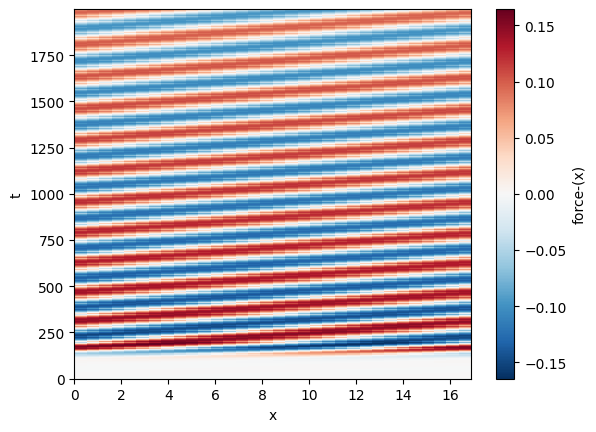

In [4]:
flds["force-(x)"].plot()

In [213]:
"""
Interpolates the E field on a periodic domain at the given points `xs`.
The E field parameter contains values of E at Fourier collocation points.
"""
def interpolate_electric_field(E, xs):
    dx = flds.x.data[0] * 2
    L = flds.x.data[-1] + dx/2
    E_modes = jnp.fft.fft(E.data)
    N = len(E)
    mode_numbers = jnp.fft.fftfreq(len(E)) * N
    # Form the trigonometric Vandermonde matrix.
    # Its rows correspond to Fourier modes, and its columns to the points xs.
    # Need to shift `xs` to the domain starting at x=0, because that's what the
    # FFT assumed about the E array.
    A = jnp.exp(2*jnp.pi*1j * (xs - dx/2) / L * jnp.reshape(mode_numbers, (N, 1))) / N
    
    return jnp.real(A.T @ modes)


"""
Accepts an array of particle positions at time t^n, and corresponding particle velocities
at time t^{n-1/2}.
"""
def leapfrog_push(xs, vs, n, dt):
    E = flds["force-(x)"][n].data
    Fs = interpolate_electric_field(E, xs)
    vs_next = vs + Fs * dt
    xs_next = xs + vs_next * dt
    # Clamp the positions to the spatial domain
    dx = flds.x.data[0] * 2
    L = float(flds.x.data[-1] + dx/2)
    xs_next = jnp.mod(xs_next, jnp.array([L]))
    
    return xs_next, vs_next


"""
Performs the single half timestep push necessary to kick off the Leapfrog method.
"""
def leapfrog_start(x0s, v0s, dt):
    E = flds["force-(x)"][0].data
    fs = interpolate_electric_field(E, x0s)
    vs_next = v0s + fs*dt/2
    return x0s, vs_next


def leapfrog_runner(x0s, v0s, dt):
    xs, vs = leapfrog_start(x0s, v0s, dt)
    x_history = jnp.empty((0, len(x0s)))
    v_history = jnp.empty((0, len(x0s)))
    # for n in jnp.arange(len(flds["force-(x)"])):
    for n in range(400):
        xs, vs = leapfrog_push(xs, vs, n, dt)
        x_history = jnp.vstack((x_history, xs))
        v_history = jnp.vstack((v_history, vs))

    return x_history, v_history

dt = flds.t.data[1]
xs, vs = leapfrog_runner(jnp.zeros(10), jnp.arange(10)/10, dt)

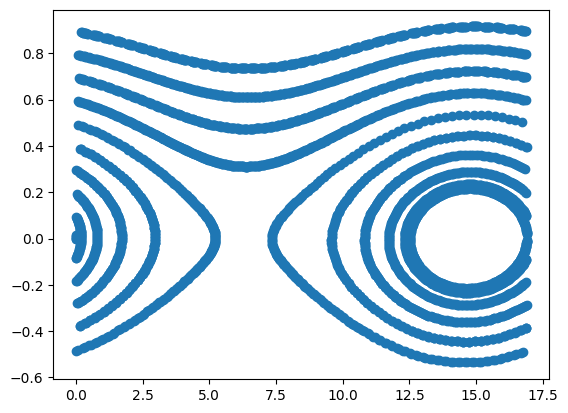

In [214]:
fig = plt.figure()
plt.scatter(xs, vs)